# 0. API KEY 로드

In [ ]:
from dotenv import load_dotenv

load_dotenv()

# 1. 카드 정보 추출 
카드 정보 추출은 다음과 같이 진행한다. 

- 홈페이지에 있으며 단종되지 않은 카드

    - 홈페이지에 있는 카드
        - O: is_visible: true
        - X: is_visible: False
    - 카드 신청 가능한 카드 목록 
        - 신청 가능: is_discon == False
        - 신청 불가능: is_discon == True

- 추출할 정보 
    - 카드 ID: card_id
    - 카드 회사: corp > name
    - 카드 이름: name 
    - 카드 종류: card_type (신용카드 == "CRD", 체크카드 == "CKD")
    - 카드 혜택(요약): top_benefit > tags(내용), title
    - 
    - 카드 신청 링크: request_pc, request_m

    카드 신청 링크와 이미지는 따로 저장한다.



In [ ]:
import json
import requests
from tqdm import tqdm

BASE_URL = "https://api.card-gorilla.com:8080/v1/cards/"  # 키드 정보 불러오기 
SAVE_PATH = "./total_card_info.json"   # 파일 저장할 이름

cards = []
for card_id in tqdm(range(1, 3000)):
    url = f"{BASE_URL}{card_id}"
    try:
        res = requests.get(url, timeout=5)
        if res.status_code == 200:
            data = res.json()
            if isinstance(data, list) and len(data) > 0:
                data = data[0]
            cards.append(data)
    except Exception:
        continue

with open(SAVE_PATH, "w", encoding="utf-8") as f:
    json.dump(cards, f, ensure_ascii=False, indent=2)

print(f"총 {len(cards)}개 카드 수집 완료 → '{SAVE_PATH}' 저장")


In [19]:
import json
import os
import re
import requests

# 파일 경로 설정
INPUT_PATH = "./total_card_info.json"
IMAGE_DIR = "./images"

# 파일명 정규화 함수
def normalize_filename(text):
    text = re.sub(r"[\\/*?\"<>|:#]", "", text or "")
    text = re.sub(r"\s+", "_", text.strip())
    return text

# 이미지 저장 함수 (안정형)
def save_card_image(card):
    # None 방어 처리
    event = card.get("event") or {}
    logo_img = event.get("logo_img") or {}
    card_img = card.get("card_img") or {}

    img_url = (
        logo_img.get("url")
        or card_img.get("url")
        or card.get("image_url")
        or card.get("image")
    )

    if not img_url:
        return None

    os.makedirs(IMAGE_DIR, exist_ok=True)

    corp_name = normalize_filename(card.get("corp", {}).get("name", "UnknownCorp"))
    card_name = normalize_filename(card.get("name", "UnknownCard"))
    filename = f"{corp_name}_{card_name}.png"
    filepath = os.path.join(IMAGE_DIR, filename)

    # 중복 저장 방지
    if os.path.exists(filepath):
        return f"./images/{filename}"

    try:
        r = requests.get(img_url, timeout=10)
        r.raise_for_status()
        with open(filepath, "wb") as f:
            f.write(r.content)
        return f"./images/{filename}"
    except requests.RequestException as e:
        print(f"[이미지 저장 실패] {card.get('name')} → {e}")
        return None


# 데이터 로드
with open(INPUT_PATH, "r", encoding="utf-8") as f:
    cards = json.load(f)

# 홈페이지 노출 + 단종 아닌 카드 정보 추출
total_cards_info = []
link_image_info = []

for card in cards:
    if card.get("is_visible") is not True:
        continue
    if card.get("is_discon") is True:
        continue

    cate = card.get("cate") or card.get("card_type")
    card_type = "신용카드" if cate == "CRD" else "체크카드" if cate == "CHK" else "기타"

    # 기본 정보
    card_info = {
        "card_id": card.get("idx"),
        "name": card.get("name"),
        "card_type": card_type,
        "top_benefit": [
            {"title": b.get("title"), "tags": b.get("tags")}
            for b in card.get("top_benefit", [])
        ]
    }
    total_cards_info.append(card_info)

    # 링크·이미지 정보
    link_info = {
        "card_id": card.get("idx"),
        "request_pc": card.get("request_pc"),
        "request_m": card.get("request_m"),
        "image": save_card_image(card) or "이미지 없음"
    }
    link_image_info.append(link_info)

print("홈페이지 + 발급 가능 카드 수:", len(total_cards_info))

# JSON 파일 저장
with open("./cards_info.json", "w", encoding="utf-8") as f:
    json.dump(total_cards_info, f, ensure_ascii=False, indent=2)

with open("./cards_link_image.json", "w", encoding="utf-8") as f:
    json.dump(link_image_info, f, ensure_ascii=False, indent=2)

print("cards_info.json, cards_link_image.json 저장 완료")


홈페이지 + 발급 가능 카드 수: 1168
cards_info.json, cards_link_image.json 저장 완료


In [20]:
with open("./cards_info.json", "r", encoding="utf-8") as f:
    card_data = json.load(f)
    
print("card data type: ", type(card_data))    
card_data[:2]

card data type:  <class 'list'>


[{'card_id': 8,
  'name': '신한카드 The CLASSIC-Y',
  'card_type': '신용카드',
  'top_benefit': [{'title': '선택형', 'tags': ['Gift Option', '매년1회', '선택이용']},
   {'title': '모든가맹점', 'tags': ['마이신한포인트', '0.7~5%', '적립']},
   {'title': '주유소', 'tags': ['GS칼텍스', '60원/L', '할인']}]},
 {'card_id': 10,
  'name': '신한카드 B.Big(삑)',
  'card_type': '신용카드',
  'top_benefit': [{'title': '대중교통', 'tags': ['대중교통', '200~600원', '할인']},
   {'title': '택시', 'tags': ['택시', '10%', '할인']},
   {'title': '기차', 'tags': ['KTX ', '10%', '할인']}]}]

In [22]:
# 홈페이지 카드 수와 일치하는지 확인
# 홈페이지 신용카드: 800, 체크카드: 368

import json
from collections import Counter

# 저장된 파일 불러오기
FILE_PATH = "./cards_info.json"

with open(FILE_PATH, "r", encoding="utf-8") as f:
    cards = json.load(f)

# 카드종류별 개수 계산
count = Counter(c.get("card_type", "기타") for c in cards)

# 결과 출력
print("카드 종류별 개수")
for k, v in count.items():
    print(f"{k}: {v}개")

print(f"총 카드 수: {sum(count.values())}개")


카드 종류별 개수
신용카드: 800개
체크카드: 368개
총 카드 수: 1168개


# 2. RAG ststem 실행

사용 전 비용 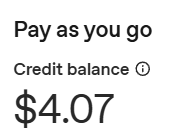

In [23]:
import json
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma 

# 1. 데이터 로드 
with open("./cards_info.json", "r", encoding="utf-8") as f:
    docs = json.load(f)

# 2. 문서 분할 (split)
splitter = RecursiveCharacterTextSplitter()
split_docs = splitter.create_documents([str(dict_) for dict_ in docs]) # 해당 함수는 list[str]형태만 받아들이기 때문에 docs의 요소들을 str으로 변환하는 작업이 필요함

# 3. 임베딩 객체 정의 
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

# 4. vectorstore 정의 
vectorstore = Chroma.from_documents(
    documents=split_docs,
    embedding=embedding,
    persist_directory="./Chroma",
    collection_name="Card_recommendation_chatbot"
)

# vectorstore= Chroma(
#     embedding_function=embedding,
#     persist_directory="./Chroma",
#     collection_name="Card_recommendation_chatbot"
# )

# 5. retreiver 
retreiver = vectorstore.as_retriever()
result = retreiver.invoke("온라인 쇼핑 혜택이 좋은 카드가 뭘까?")

print(len(result))
for page in result:
    print(page.page_content)
    print("-"*50)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


4
{'card_id': 274, 'name': '쇼핑앤조이 카드', 'card_type': '신용카드', 'top_benefit': [{'title': '대중교통', 'tags': ['버스, 지하철, 택시', '5%', '할인']}, {'title': '온라인쇼핑', 'tags': ['온라인쇼핑', '5,000원', '할인']}, {'title': '카페', 'tags': ['스타벅스', '2,000원', '할인']}]}
--------------------------------------------------
{'card_id': 575, 'name': '라이프+플러스 체크카드', 'card_type': '체크카드', 'top_benefit': [{'title': '온라인쇼핑', 'tags': ['온라인 쇼핑', '10%', '혜택']}, {'title': '애완동물', 'tags': ['반려동물관련', '10%', '혜택']}, {'title': '해외', 'tags': ['해외가맹점', '1%', '혜택']}]}
--------------------------------------------------
{'card_id': 526, 'name': 'NH농협 올바른LIFE카드(할인형)', 'card_type': '신용카드', 'top_benefit': [{'title': '온라인쇼핑', 'tags': ['온라인쇼핑', '3%', '할인']}, {'title': '카페', 'tags': ['커피전문점', '5%', '할인']}, {'title': '통신', 'tags': ['이동통신요금', '2천원', '할인']}]}
--------------------------------------------------
{'card_id': 1586, 'name': '신협-신한카드 Shopping', 'card_type': '신용카드', 'top_benefit': [{'title': '쇼핑', 'tags': ['온ㆍ오프라인', '10%', '할인']}, {'title'

In [24]:
print(type(docs))
print(type(docs[0]))

<class 'list'>
<class 'dict'>


# 3. Streamlit과 연동하기

In [26]:
%%writefile chatbot/card_gpt.py 

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.memory import ConversationBufferMemory
from langchain_core.runnables import RunnableLambda
from dotenv import load_dotenv

load_dotenv()

Writing chatbot/card_gpt.py
